## Regression 실습 - 자전거 대여 수요

### 데이터 클렌징 및 가공

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

bike_df = pd.read_csv('bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [9]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


모든 열을 int와 float 형식으로 만들어 주기 위해서 bike_df의 datetime열을 year, month, day, hour로 나누어서 표현한 후 제거 

In [10]:
# datetime 타입으로 변경하는 것은 시간이 오래걸리는 방법으로 추천하지는 않으나
# 인덱싱을 이용하면 가독성이 떨어져 일단은 이대로 진행

# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime타입에서 년, 월, 일 ,시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


- datetime 컬럼이 여러 열로 쪼개져 표현되었으므로 datetime 컬럼을 삭제함
- casual과 registered도 count와의 상관관계를 고려해 삭제(EDA에 필요할 수는 있음)

In [11]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis = 1, inplace = True)

In [12]:
#결과 확인
bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


데이터를 제공한 캐글 컴피티션에서 요구한 평가방법은 RMSLE이지만 sklearn에서는 제공하지 않음, 따라서 직접 RMSLE를 구하는 함수를 만들어야함

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log값 변환 시 NaN(0을 지수로 가지는 경우) 등의 이슈로 
# log가 아닌 log1p를 이용해 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷 런의 mean_squared_error()를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE:{0:.3f}, RMSE:{1:.3f}, MAE:{2:.3f}'.format(rmsle_val, rmse_val, mae_val))    

### 로그변환, 피쳐 인코딩, 모델학습/예측/평가

#### 로그변환 X, 인코딩 X의 설정으로 모델학습

In [14]:
# 로그변환 및 인코딩 등을 적용하지 않고 일반적인 세팅으로만 모델을 학습

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_feature = bike_df.drop('count',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size = 0.3, random_state = 0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE:1.165, RMSE:140.900, MAE:105.924


꽤 높은 오류값이 나온 것을 알 수 있음(대여량이 평균적으로 100개 정도 차이가 남)  
이를 확인 하기위한 함수를 만들어보자

In [16]:
def get_top_error_data(y_test, pred, n_tops = 5):
    # DataFrame에 컬럼들로 실제 대여횟수(count)와 예측값을 서로 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns = ['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    # 예측값과 실제값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values(by = 'diff', ascending = False)[:n_tops])

get_top_error_data(y_test, pred, n_tops = 5)    

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


차이가 심하게 나는 것은 500개 이상 차이가 나는 것을 확인

- 로그변환을 통해 왜곡정도를 완화시킴 (왼쪽 = 원본, 오른쪽 = 로그변환)

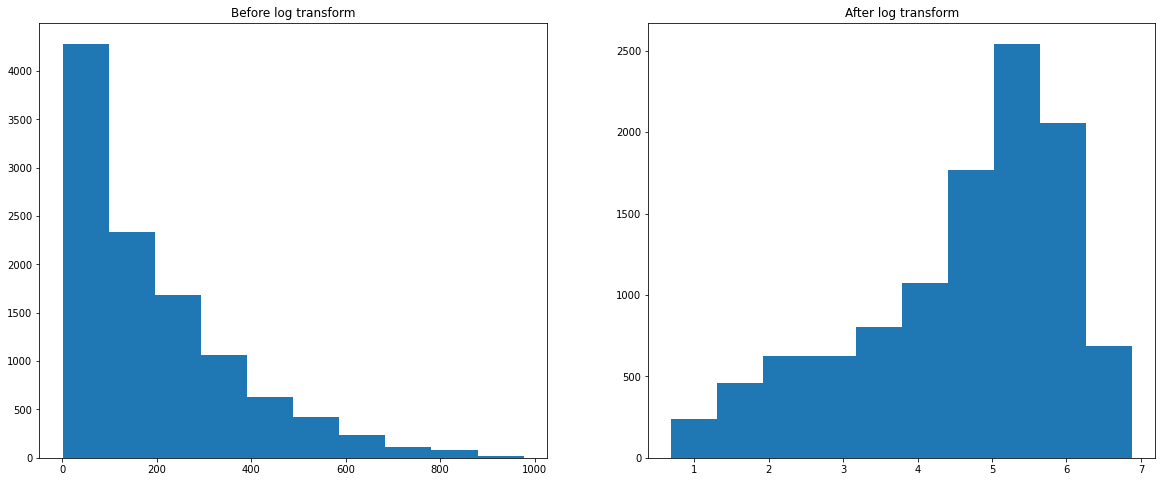

In [23]:
fig, ax = plt.subplots(1,2, figsize = (20,8))
ax[0].hist(y_target)
ax[0].set_title('Before log transform')

y_log_transform = np.log1p(y_target)
ax[1].hist(y_log_transform)
ax[1].set_title('After log transform')
plt.show()

#### 로그변환 O, 인코딩 X의 설정으로 모델학습

In [24]:
# 타켓 컬럼인 count 값을 log1p로 log변환
y_target_log = np.log1p(y_target)

# 로그변환된 y_target_log를 반영하여 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target_log, test_size = 0.3, random_state = 0)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 셋의 Target 값은 Log 변환되었으므로 다시 expm1를 이용하여 원래 scale로 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 Log변환된 타겟 기반으로 학습되어 예측되었으므로 다시 expm1으로 sclae 조정
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE:1.017, RMSE:162.594, MAE:109.286


RMSLE는 개선되었지만 다른 지표들은 모두 값이 높아짐  
이유를 살펴보기 위해서 coef값 확인

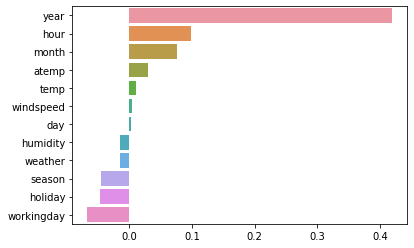

In [25]:
coef = pd.Series(lr_reg.coef_, index = X_feature.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x = coef_sort.values, y=coef_sort.index)
plt.show()

- year, month, hour등의 변수들이 차지하는 비중이 높음  
- 특히 year는 자전거와는 크게 상관이 없으나 숫자형 카테고리 변수의 특성상 크기가 크면 예측에 영향을 주는 경우가 많음 
- 이를 제어하기 위해 원핫인코딩을 적용


#### 로그변환 O, (원핫)인코딩 O의 설정으로 모델학습

In [26]:
# 숫자형 카테고리 값인 컬럼들을 모두 원핫인코딩
X_feature_ohe = pd.get_dummies(X_feature, columns = ['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])

In [33]:
# 원핫 인코딩이 적용된 feature 데이터 세트 기반으로 학습/예측 데이터 분할.
X_train, X_test, y_train, y_test = train_test_split(X_feature_ohe, y_target_log,
                                                    test_size = 0.3, random_state = 0)

# 모델과 학습/테스트 데이터 셋을 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1 = False):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print("###", model.__class__.__name__,"###")
    evaluate_regr(y_test,pred)
    
# 모델별로 평가수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha = 10)
lasso_reg = Lasso(alpha = 0.01)
    
for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1= True)
    

### LinearRegression ###
RMSLE:0.590, RMSE:97.687, MAE:63.382
### Ridge ###
RMSLE:0.590, RMSE:98.529, MAE:63.893
### Lasso ###
RMSLE:0.635, RMSE:113.219, MAE:72.803


- 성능이 인코딩 전보다 많이 나아졌음을 직관적으로 확인이가능함
- 피쳐 중요도를 살펴보면 이전과 달리 더 세분화해서 나타났음을 알 수 있음

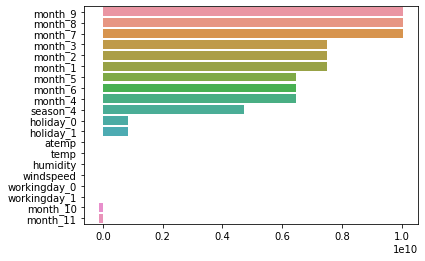

In [34]:
coef = pd.Series(lr_reg.coef_ , index=X_feature_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

#### 로그변환 O, (원핫)인코딩 O의 설정 및 회귀트리를 이용한 예측

In [37]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500, objective='reg:tweedie')
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    # XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE:0.355, RMSE:50.365, MAE:31.196
### GradientBoostingRegressor ###
RMSLE:0.330, RMSE:53.322, MAE:32.736
### XGBRegressor ###
RMSLE:0.344, RMSE:55.284, MAE:34.393
### LGBMRegressor ###
RMSLE:0.319, RMSE:47.215, MAE:29.029


- 선형회귀보다 성능이 더 나아졌음을 확인할 수 있지만 이것이 회귀트리가 더 좋은 알고리즘이라 그런 것은 아님
- 데이터유형에 따라 선형회귀가 더 잘 맞는 문제가 존재 가능